# Preparation
## Load The Package

In [1]:
# import hbsir

# The following code is written to import hbsir library from this
# repository without installation. Usually, you can import the library
# by writing "import hbsir"

import pandas as pd
from pdf2image import pdf2image

try:
    import hbsir

except ModuleNotFoundError:
    import sys
    from pathlib import Path

    for parent in Path().absolute().parents:
        if len(list(parent.glob("hbsir"))) > 0:
            hbsir_path = parent
            break
    else:
        raise FileNotFoundError

    sys.path.append(str(hbsir_path))

    import hbsir

## Open The Report

In [2]:
try:
    with open("summery-results.pdf", mode="rb") as pdf_file:
        pdf_content = pdf_file.read()
except FileNotFoundError:
    import requests

    url = r"https://www.amar.org.ir/LinkClick.aspx?fileticket=Sxo6JC4OCi8%3d&portalid=1"
    report_file = requests.get(url)
    pdf_content = report_file.content
    with open("summery-results.pdf", mode="wb") as pdf_file:
        pdf_file.write(pdf_content)
report_pages = pdf2image.convert_from_bytes(pdf_content, dpi=100)

# Household Income and Expenditure at a Glance
## Table 1
Total annual net and gross expenditure of an urban and rural household on food and tobacco and non-food items, the years 1399 and 1400

### Table Content

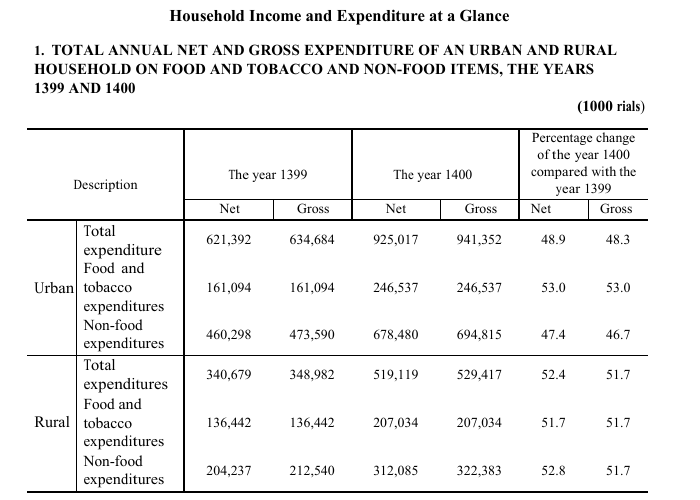

In [3]:
expenditure_summery_table = report_pages[3].crop((50, 60, 750, 560))
expenditure_summery_table

In [4]:
table = hbsir.load_table("Expenditures", [1399, 1400])
table = hbsir.add_classification(table, "Food-NonFood")
table = hbsir.add_weight(table)
table["Weighted_Gross_Expenditure"] = table.eval("Gross_Expenditure * Weight")
table["Weighted_Net_Expenditure"] = table.eval("Net_Expenditure * Weight")
table.head(10)

,Year,ID,Code,Provision_Method,Amount,Price,Gross_Expenditure,Net_Expenditure,Food-NonFood,Weight,Weighted_Gross_Expenditure,Weighted_Net_Expenditure
0,1399,10005004618,11143,Purchase,3.00,20000.0,720000.0,720000.0,Food,344.785188,2.482453e+08,2.482453e+08
1,1399,10005004618,11151,Purchase,10.00,20000.0,2400000.0,2400000.0,Food,344.785188,8.274845e+08,8.274845e+08
2,1399,10005004618,11164,Purchase,1.40,90000.0,1512000.0,1512000.0,Food,344.785188,5.213152e+08,5.213152e+08
3,1399,10007007226,11112,Purchase,10.00,230000.0,27600000.0,27600000.0,Food,427.669228,1.180367e+10,1.180367e+10
4,1399,10007007226,11151,Purchase,25.00,20000.0,6000000.0,6000000.0,Food,427.669228,2.566015e+09,2.566015e+09
5,1399,10007007226,11164,Purchase,1.15,80000.0,1104000.0,1104000.0,Food,427.669228,4.721468e+08,4.721468e+08
6,1399,10007007226,11212,Purchase,5.00,900000.0,54000000.0,54000000.0,Food,427.669228,2.309414e+10,2.309414e+10
7,1399,10007007226,11231,Purchase,6.50,121000.0,9438000.0,9438000.0,Food,427.669228,4.036342e+09,4.036342e+09
8,1399,10007007226,11412,Purchase,10.00,30000.0,3600000.0,3600000.0,Food,427.669228,1.539609e+09,1.539609e+09
9,1399,10007007226,11428,Purchase,1.00,180000.0,2160000.0,2160000.0,Food,427.669228,9.237655e+08,9.237655e+08


In [5]:
household_table = table.groupby(["Year", "ID", "Food-NonFood"])[
    ["Weighted_Gross_Expenditure", "Weighted_Net_Expenditure"]
].sum()
household_table = hbsir.add_attribute(household_table, "Urban-Rural")
household_table.head(10)

Weighted_Gross_Expenditure  \
Year ID          Food-NonFood                               
1399 10001000113 Food                        3.362289e+11   
                 Non-Food                    1.054282e+12   
     10001000116 Food                        5.091164e+11   
                 Non-Food                    9.543348e+11   
     10001000120 Food                        4.423810e+11   
                 Non-Food                    8.196236e+11   
     10001000123 Food                        3.798687e+11   
                 Non-Food                    8.560255e+11   
     10001000126 Food                        2.339921e+11   
                 Non-Food                    3.670255e+11   

                               Weighted_Net_Expenditure Urban-Rural  
Year ID          Food-NonFood                                        
1399 10001000113 Food                      3.362289e+11       Urban  
                 Non-Food                  1.054282e+12       Urban  
     10001000116 Food                      5.091164e+11       Urban  
                 Non-Food                  9.543348e+11       Urban  
     10001000120 Food                      4.423810e+11       Urban  
                 Non-Food                  8.196236e+11       Urban  
     10001000123 Food                      3.798687e+11       Urban  
                 Non-Food                  8.560255e+11       Urban  
     10001000126 Food                      2.339921e+11       Urban  
                 Non-Food                  3.670255e+11       Urban

In [6]:
weights = hbsir.load_table("Weights", years=[1399, 1400])
weights = hbsir.add_attribute(weights, "Urban-Rural")
weights_sum = weights.groupby(["Year", "Urban-Rural"])["Weight"].sum()
weights_sum.to_frame()

Weight
Year Urban-Rural            
1399 Rural         6127118.0
     Urban        20061995.0
1400 Rural         6135626.0
     Urban        20557988.0

In [7]:
summery_table = household_table.groupby(["Year", "Food-NonFood", "Urban-Rural"])[
    ["Weighted_Net_Expenditure", "Weighted_Gross_Expenditure"]
].sum()
summery_table.columns = ["Net", "Gross"]
summery_table.columns.name = "Net-Gross"
summery_table = summery_table.stack().unstack([0, 2])
summery_table = summery_table / weights_sum
summery_table = summery_table.unstack(1)
summery_table.loc["Total"] = summery_table.sum()
summery_table = summery_table.stack(1)
summery_table = summery_table.reorder_levels(["Urban-Rural", "Food-NonFood"])
summery_table = summery_table / 1000
summery_table

Year                               1399                          1400  \
Net-Gross                         Gross            Net          Gross   
Urban-Rural Food-NonFood                                                
Rural       Food          136441.741231  136441.741231  207036.586454   
Urban       Food          161094.096516  161094.096516  246537.088639   
Rural       Non-Food      212540.375490  204237.035910  322389.461074   
Urban       Non-Food      473589.564267  460297.811398  694814.393088   
Rural       Total         348982.116721  340678.777140  529426.047528   
Urban       Total         634683.660783  621391.907914  941351.481727   

Year                                     
Net-Gross                           Net  
Urban-Rural Food-NonFood                 
Rural       Food          207036.586454  
Urban       Food          246537.088639  
Rural       Non-Food      312090.109679  
Urban       Non-Food      678478.557964  
Rural       Total         519126.696133  
Urban       Total         925015.646603

In [8]:
def sort_key(index: pd.Index, dictionary: dict):
    index = index.map(dictionary)
    index = index.astype(int)
    return index


index_order = {
    "Total": 1,
    "Food": 2,
    "Non-Food": 3,
    "Urban": 11,
    "Rural": 12,
}
column_order = {
    "Net": 1,
    "Gross": 2,
    1399: 11,
    1400: 12,
}
summery_table = summery_table.sort_index(
    axis="index", key=lambda i: sort_key(i, index_order)
)
summery_table = summery_table.sort_index(
    axis="columns", key=lambda i: sort_key(i, column_order)
)
summery_table.loc[:, ("Percentage_Change", "Net")] = (
    summery_table.loc[:, (1400, "Net")] / summery_table.loc[:, (1399, "Net")] - 1
) * 100
summery_table.loc[:, ("Percentage_Change", "Gross")] = (
    summery_table.loc[:, (1400, "Gross")] / summery_table.loc[:, (1399, "Gross")] - 1
) * 100

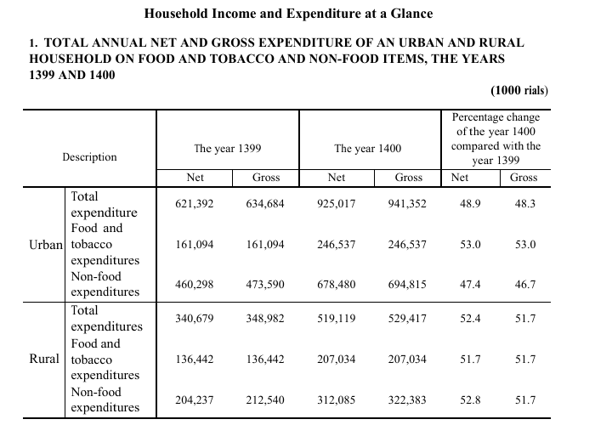

In [9]:
final_table = summery_table.style
final_table = final_table.format("{:,.0f}", subset=[1399, 1400])
final_table = final_table.format("{:,.1f}", subset=["Percentage_Change"])

image_size = expenditure_summery_table.size
scale = 0.85
new_size = tuple(int(num * scale) for num in image_size)
final_image = expenditure_summery_table.resize(new_size)

display(final_image, final_table)

## Table 2
Annual Income of an urban and rural household in the years 1399 and 1400

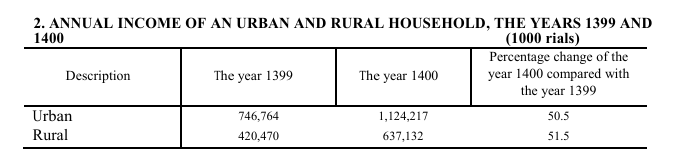

In [10]:
income_summery_table = report_pages[3].crop((50, 570, 750, 730))

image_size = income_summery_table.size
scale = 0.8
new_size = tuple(int(num * scale) for num in image_size)
final_image = income_summery_table.resize(new_size)
income_summery_table

In [11]:
total_income = (
    hbsir.load_table("Total_Income", years=[1399, 1400])
    .hbsir.add_attribute(attribute_name="Urban-Rural")
    .hbsir.add_weight()
    .assign(Weighted_Income=lambda t: t.eval("Income * Weight"))
)
total_income.head()

,Year,ID,Income,Urban-Rural,Weight,Weighted_Income
0,1399,10001000113,1.120990e+09,Urban,1221.992817,1.369842e+12
1,1399,10001000116,8.340000e+08,Urban,1221.992817,1.019142e+12
2,1399,10001000120,1.169920e+09,Urban,1221.992817,1.429634e+12
3,1399,10001000123,1.428942e+09,Urban,1221.992817,1.746157e+12
4,1399,10001000126,3.721100e+08,Urban,1221.992817,4.547157e+11


Year,1399,1400,Percentage_Change
Urban-Rural,,,
Urban,"746,764","1,124,214",50.5
Rural,"420,470","637,147",51.5


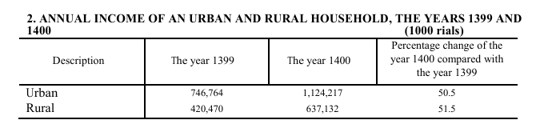

In [12]:
final_table = (
    total_income.groupby(["Year", "Urban-Rural"])[["Weighted_Income", "Weight"]]
    .sum()
    .assign(Weighted_Mean=lambda t: t.eval("Weighted_Income / Weight"))
    .loc[:, ["Weighted_Mean"]]
    .div(1000)
    .unstack(0)
    .droplevel(0, axis="columns")
    .sort_index(ascending=False)
    .assign(Percentage_Change=lambda t: (t[1400] / t[1399] * 100) - 100)
    .style.format("{:,.0f}", subset=[1399, 1400])
    .format("{:,.1f}", subset=["Percentage_Change"])
)
display(final_table, final_image)

## Table 4

In [13]:
items = [
    "Car",
    "Motorcycle",
    "Bicycle",
    "TV_CR",
    "Freezer",
    "Refrigerator",
    "Frizer_Refrigrator",
    "Oven",
    "Vaccum",
    "Washer",
    "Dishwasher",
    "Microwave",
]
(
    hbsir.load_table("house_specifications")
    .pipe(hbsir.add_attribute, "Urban-Rural")
    .pipe(hbsir.add_weight)
    .astype({column: float for column in items})
    .eval("\n".join([f"{column} = {column} * Weight" for column in items]))
    .groupby("Urban-Rural")[items + ["Weight"]].sum()
    .eval("\n".join([f"{column} = {column} / Weight * 100" for column in items]))
    .drop(columns="Weight")
    .T
    .style
    .format("{:,.1f}")
)

Urban-Rural,Rural,Urban
Car,35.9,53.9
Motorcycle,24.5,12.7
Bicycle,6.7,9.9
TV_CR,95.1,97.6
Freezer,12.1,19.0
Refrigerator,46.4,31.4
Frizer_Refrigrator,55.2,70.7
Oven,98.5,98.8
Vaccum,68.9,92.1
Washer,59.7,88.1
